In [22]:
from matplotlib import pyplot as plt
from tabulate import tabulate
import numpy as np
import cv2

In [23]:
# Steps

NNN = 256

T_STEP = int(40 / 10) + 1
I_STEP = int(NNN / 20) + 1

%run -i ./ownlib/PHT-Library3.ipynb
%run -i ./ownlib/RIW-Library3.ipynb
%run -i ./ownlib/Utility.ipynb
%run -i ./ownlib/Inverse-Geometric.ipynb

In [24]:
# Import images
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/paperplane.png', 0)

In [25]:
def ecute(n, g, p, d):
    # Preprocess Image
    IMG_BGR = cv2.resize(ori_img, (n, n)) # Original Image
    IMG_Y = getYFromBGR(IMG_BGR) #

    # Preprocess Logo
    LOGO = cv2.resize(ori_logo, (g,g))
    LOGO = (LOGO >= 128) * 1
    
    # Scrambling Logo
    LOGO_SC = scramble(LOGO)
    
    # Transform
    MOMEN = transformPHT(IMG_Y, n, p, 'Transform Image, N={} G={} P={} D={}'.format(n, g, p, d))
    
    # Embedding
    (LOGO_POSITIONED, LOGO_FILTER, maxCapacity) = watermarkEmbed(LOGO, p)
    
    # Calculate Momen Changes
    MOMEN_EXPECTED = 2 * d * np.round(np.abs(MOMEN) / 2 / d)
    MOMEN_EXPECTED = MOMEN_EXPECTED + d / 2 * (LOGO_POSITIONED == 1)
    MOMEN_EXPECTED = MOMEN_EXPECTED - d / 2 * (LOGO_POSITIONED == 0)
    MOMEN_EXPECTED = MOMEN_EXPECTED + 2 * d * (MOMEN_EXPECTED < 0)

    MOMEN_DIFF = MOMEN_EXPECTED - np.abs(MOMEN)
    MOMEN_DIFF = MOMEN_DIFF / (np.abs(MOMEN) + 0.000000001) * MOMEN

    OMEGA = MOMEN_DIFF * LOGO_FILTER
    
    # Compensation Image
    IMG_COMPENSATION = inversePHT(OMEGA, n, p, 'Generating Compensation Image N={} G={} P={} D={}'.format(n, g, p, d))
    
    # Watermarking
    IMG_Y_WATERMARKED = IMG_Y + IMG_COMPENSATION
    IMG_WATERMARKED = putYToBGR(IMG_Y_WATERMARKED, IMG_BGR)
    
    # Calculate PSNR
    MSE = np.mean((IMG_WATERMARKED - IMG_BGR) ** 2)
    PSNR = 10 * np.log10(255 * 255 / MSE)
    
    # Return
    return (IMG_WATERMARKED, PSNR, n, g, p, d)

In [26]:
def watermarkExtractFromImage(img, ori_img, ori_logo, n, g, p, d, message=''):
    ori_img = cv2.resize(ori_img, (n, n))
    ori_logo = (cv2.resize(ori_logo, (g, g)) >= 128) * 1
    used_img = cv2.resize(img, (n, n))
    
    # Reverse Translation
    (h, w, c) = used_img.shape
    cx = (h - 1) / 2
    (tx, ty) = correctTranslate(ori_img, used_img, (cx, cx))
    used_img = attackTranslateByPixel(used_img, tx, ty)
    
    imgY = getYFromBGR(used_img)
    
    # Calculate Momen
    (n, _) = imgY.shape
    momen = transformPHT(imgY, n, p, message)
    
    # Current Binary Value & Difference
    QQ = ((np.abs(momen) - 2 * d * np.round(np.abs(momen) / 2 / d)) > 0) * 1
    
    # Crop Watermark
    extractedLogo = watermarkExtract(QQ, p, g) # MAT_Q_MODIFIED[logo_position]
    
    # Calculate Bit Error Rate    
    be = calcBE(ori_logo, extractedLogo)
    ber = be / (g * g)
    
    return (extractedLogo, ber)

In [27]:
def war(image, n):
    attackedImages = []
    
    # No Attack
    attackedImages.append((np.copy(image), 'No Attack'))
    
    # Attack: Rotation
    ROTATION_ANGLE = 45
    imgRotate = attackRotation(image, ROTATION_ANGLE)
    attackedImages.append((imgRotate, 'Rotation {}° CW'.format(ROTATION_ANGLE)))
    
    # Attack: Scaling
    RESIZE_FACTOR = 1.25
    imgResize = attackResize(image, int(RESIZE_FACTOR * n))
    attackedImages.append((imgResize, 'Scaling ' + '{:.0%}'.format(RESIZE_FACTOR)))
    
    # Attack: Translation
    TR_X = 0.05
    TR_Y = -0.05
    imgTranslate = attackTranslate(image, TR_X, TR_Y)
    attackedImages.append((imgTranslate, 'Translation X={:.0%} Y={:.0%}'.format(TR_X, TR_Y)))
    
    # Attack: Crop
    CROP_PERCENTAGE = 0.05
    imgCrop = attackCrop(image, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE)
    attackedImages.append((imgCrop, 'Crop {:.0%}'.format(CROP_PERCENTAGE)))
    
    # Attack: BLUR
    BLUR_KERNEL_SIZE = 3
    imgBlur = attackBlur(image, BLUR_KERNEL_SIZE)
    attackedImages.append((imgBlur, 'Blur K={}'.format(BLUR_KERNEL_SIZE)))

    # Attack: Black & Pepper Noise
    NOISE_PERCENTAGE = 0.05
    imgNoise = attackRandomNoise(image, NOISE_PERCENTAGE)
    attackedImages.append((imgNoise, 'Noise {:.0%}'.format(NOISE_PERCENTAGE)))

    # Attack: JPG Compression
    COMPRESSION_QUALITY = 90
    imgJpg = attackJPG(image, ROTATION_ANGLE)
    attackedImages.append((imgJpg, 'JPG Compression Q={}'.format(COMPRESSION_QUALITY)))
    
    return attackedImages

In [28]:
def proceso(watermarkData):
    TEST_DATA = []
    TEST_IMAGE = []
    TEST_LOGO = []
    TEST_HEADER = []

    # Process watermarked data
    for data in watermarkData[0:]:

        # Deconstruct watermarked data
        (imgWatermarked, psnr, n, g, p, d) = data

        # Original watermark
        logo = cv2.resize(ori_logo, (g,g))
        logo = (logo >= 128) * 1

        # Initialize temporary array

        logoList = []
        imgList = []
        headerList = ['N', 'G', 'P', 'D', 'PSNR']
        dataList = [n, g, p, d, psnr]

        # Get attacked image list
        imgAttackedList = war(imgWatermarked, n)

        # Process attacked image
        for imgWithTitle in imgAttackedList[0:]:

            # Extract watermark
            (imgAttack, titleAttack) = imgWithTitle
            message = 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, titleAttack)
            (logo2, ber) = watermarkExtractFromImage(imgAttack, ori_img, ori_logo, n, g, p, d, message)

            # Append column
            headerList.append(titleAttack)
            imgList.append(imgAttack)
            logoList.append(logo2)
            dataList.append(ber)

        # Append row
        TEST_HEADER = headerList
        TEST_IMAGE.append((imgList, headerList[5:]))
        TEST_LOGO.append((logoList, headerList[5:]))
        TEST_DATA.append(dataList)

    # Print result as table
    TEST_TABLE = TEST_DATA.copy()
    TEST_TABLE.insert(0, TEST_HEADER)

    return(np.array(TEST_TABLE).T, TEST_LOGO)

In [29]:
# Different Quantization Step

TEST_D = []
for dd in (0.2, 0.4, 0.6, 0.8, 1):
    pair = ecute(NNN, 12, 32, dd)
    TEST_D.append(pair)
    
clear_output(wait = True)
print(tabulate(
    list(map(lambda s: [s[2], s[3], s[4], s[5], s[1]], TEST_D)),
    headers=['N', 'G', 'P', 'D', 'PSNR'], 
    tablefmt='orgtbl'
))

|   N |   G |   P |   D |    PSNR |
|-----+-----+-----+-----+---------|
| 256 |  12 |  32 | 0.2 | 40.9313 |
| 256 |  12 |  32 | 0.4 | 36.772  |
| 256 |  12 |  32 | 0.6 | 32.9525 |
| 256 |  12 |  32 | 0.8 | 31.6763 |
| 256 |  12 |  32 | 1   | 30.9385 |


| N                      | 256          | 256          | 256         | 256         | 256         |
| G                      |  12          |  12          |  12         |  12         |  12         |
| P                      |  32          |  32          |  32         |  32         |  32         |
| D                      |   0.2        |   0.4        |   0.6       |   0.8       |   1         |
| PSNR                   |  40.9313     |  36.772      |  32.9525    |  31.6763    |  30.9385    |
| No Attack              |   0          |   0          |   0         |   0         |   0         |
| Rotation 45° CW        |   0.0763889  |   0.00694444 |   0         |   0         |   0         |
| Scaling 125%           |   0.00694444 |   0          |   0         |   0         |   0         |
| Translation X=5% Y=-5% |   0.3125     |   0.173611   |   0.0972222 |   0.0694444 |   0.0416667 |
| Crop 5%                |   0.263889   |   0.0972222  |   0.0555556 |   0.0208333 |   0.0277778 |
| Blur K=3

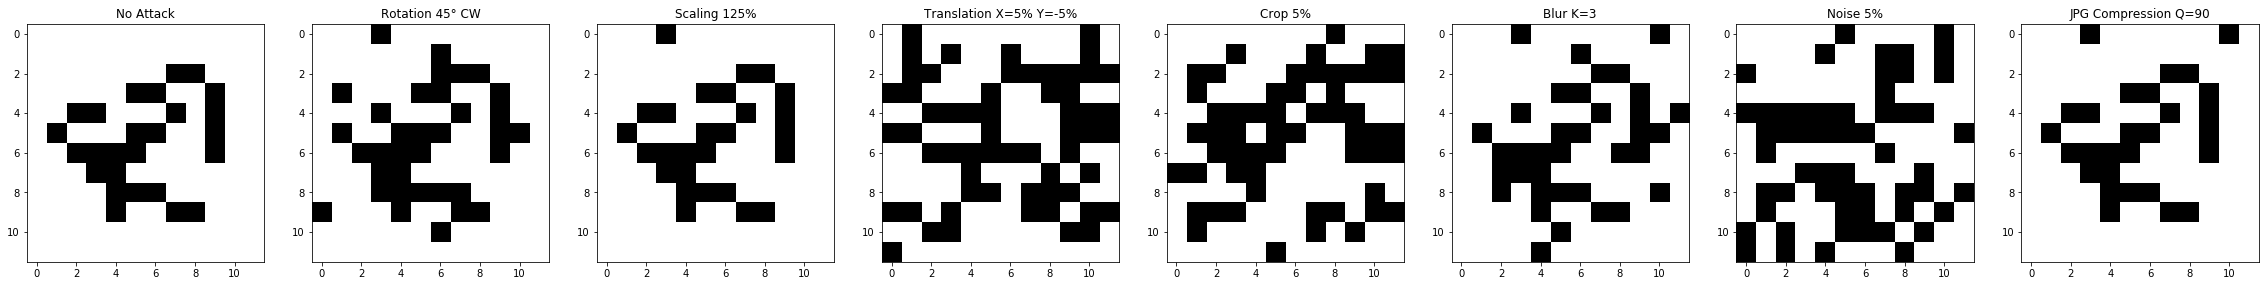

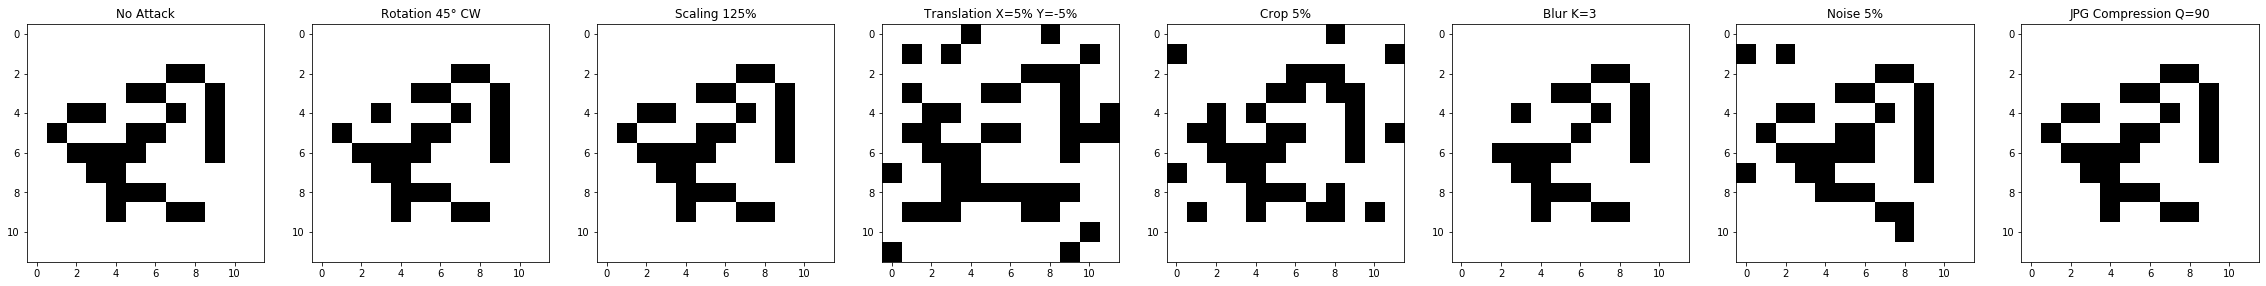

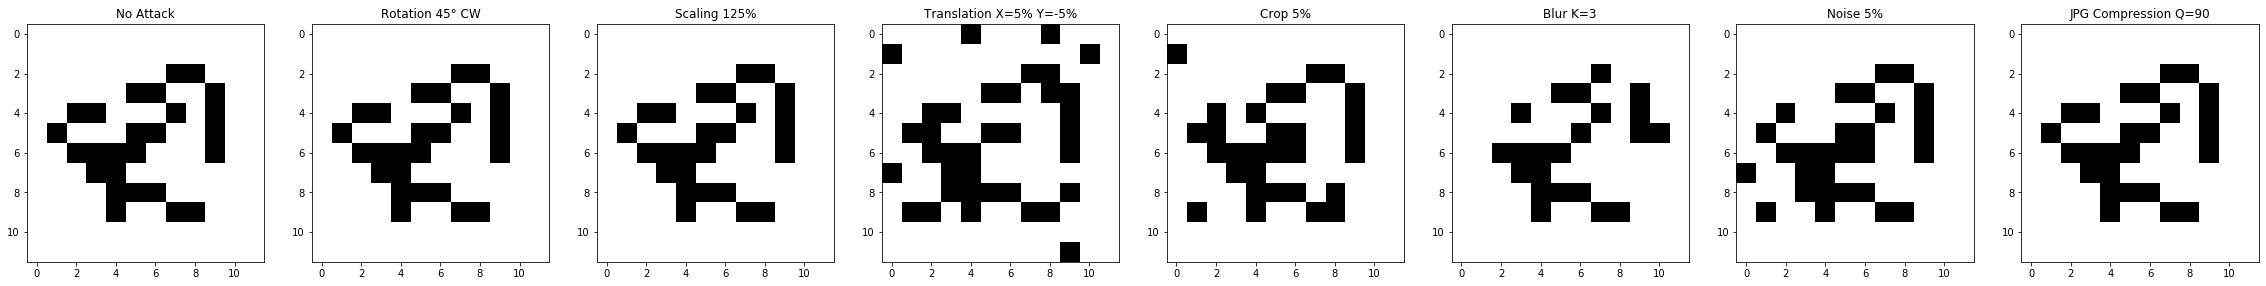

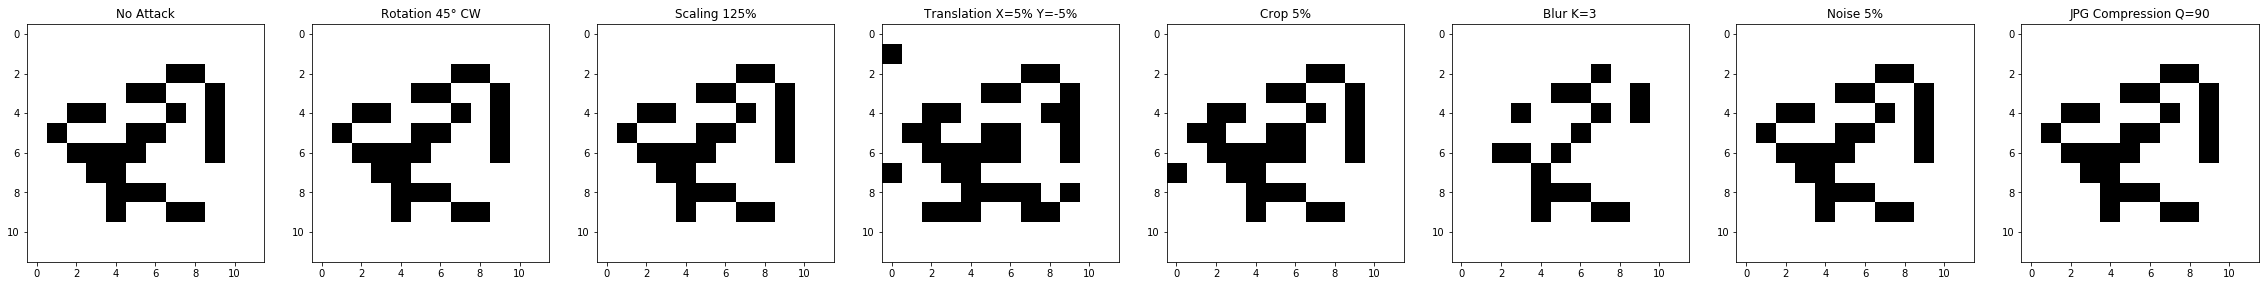

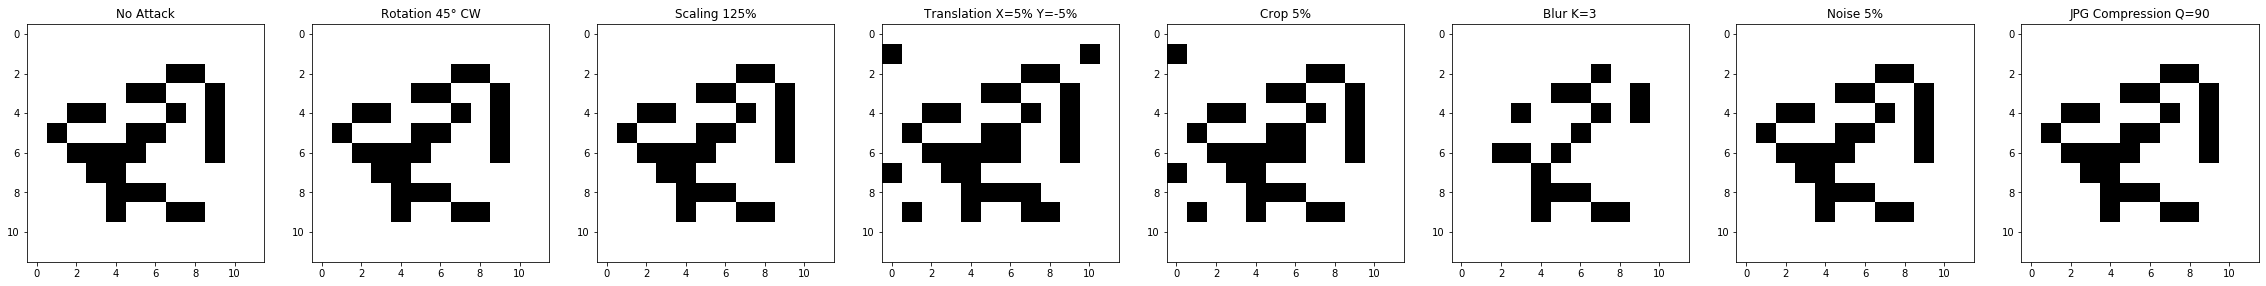

In [30]:
TEST_D_TABLE, TEST_D_LOGO = proceso(TEST_D)

clear_output(wait = True)
print(tabulate(
    np.array(TEST_D_TABLE),
    tablefmt='orgtbl'
))

for imgAndTitle in TEST_D_LOGO:
    (image, title) = imgAndTitle
    imgshow([image], [title], 5)

In [31]:
# Different Watermark Size

TEST_G = []
for gg in (8, 16, 24):
    pair = ecute(NNN, gg, 32, 0.5)
    TEST_G.append(pair)
    
clear_output(wait = True)
print(tabulate(
    list(map(lambda s: [s[2], s[3], s[4], s[5], s[1]], TEST_G)),
    headers=['N', 'G', 'P', 'D', 'PSNR'], 
    tablefmt='orgtbl'
))

|   N |   G |   P |   D |    PSNR |
|-----+-----+-----+-----+---------|
| 256 |   8 |  32 | 0.5 | 37.5855 |
| 256 |  16 |  32 | 0.5 | 32.4916 |
| 256 |  24 |  32 | 0.5 | 31.1139 |


| N                      | 256        | 256          | 256          |
| G                      |   8        |  16          |  24          |
| P                      |  32        |  32          |  32          |
| D                      |   0.5      |   0.5        |   0.5        |
| PSNR                   |  37.5855   |  32.4916     |  31.1139     |
| No Attack              |   0        |   0          |   0          |
| Rotation 45° CW        |   0        |   0.00390625 |   0.0104167  |
| Scaling 125%           |   0        |   0          |   0.00347222 |
| Translation X=5% Y=-5% |   0.0625   |   0.0976562  |   0.125      |
| Crop 5%                |   0.046875 |   0.0546875  |   0.0659722  |
| Blur K=3               |   0        |   0.0351562  |   0.0399306  |
| Noise 5%               |   0.046875 |   0.0234375  |   0.0243056  |
| JPG Compression Q=90   |   0        |   0.00390625 |   0.00520833 |


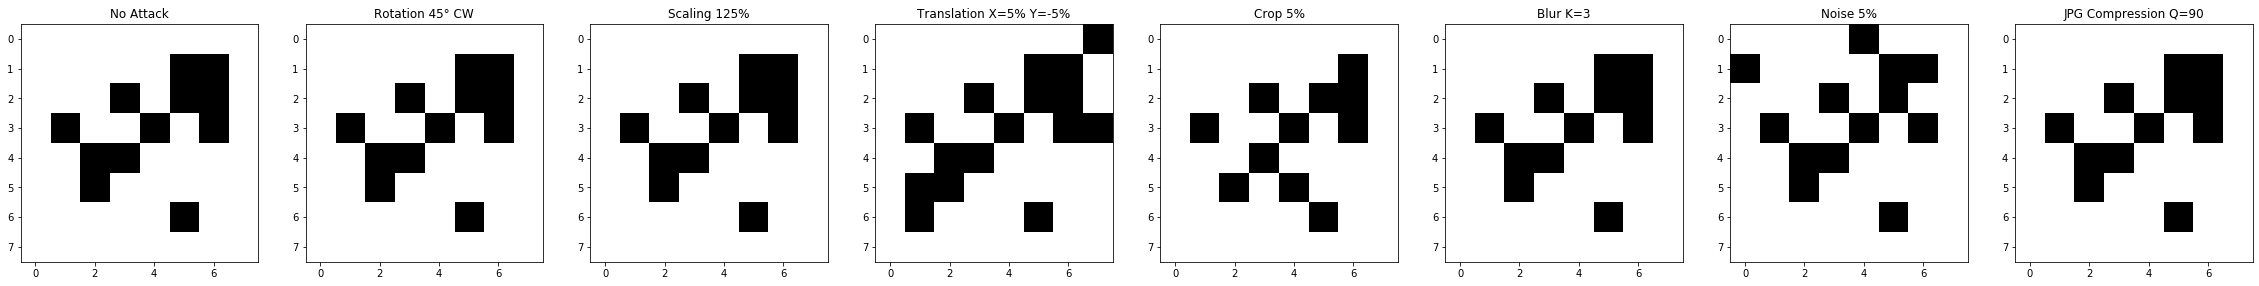

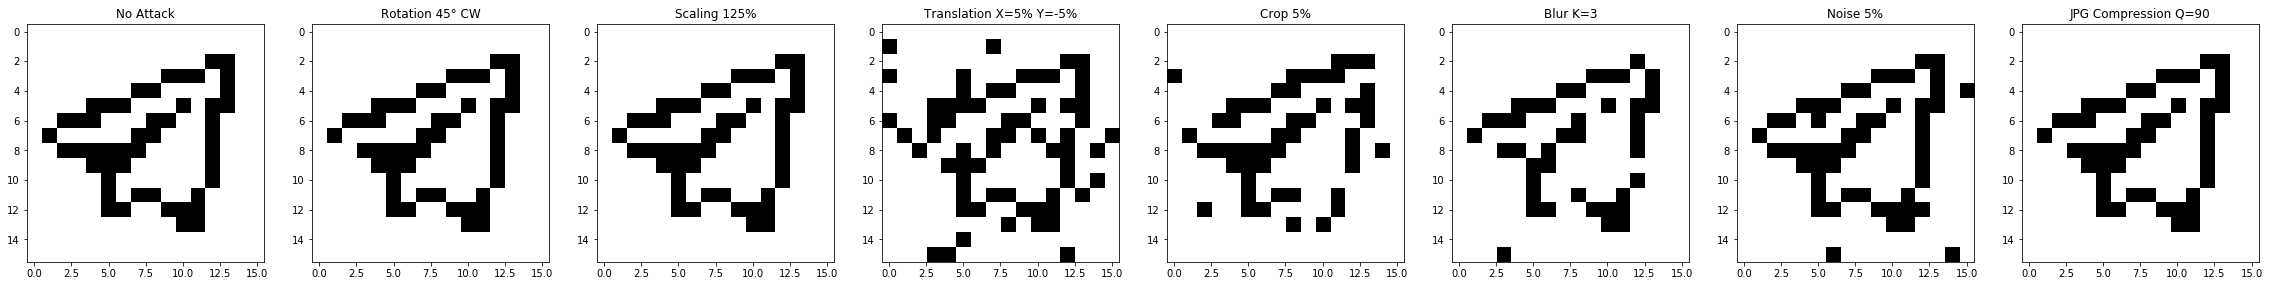

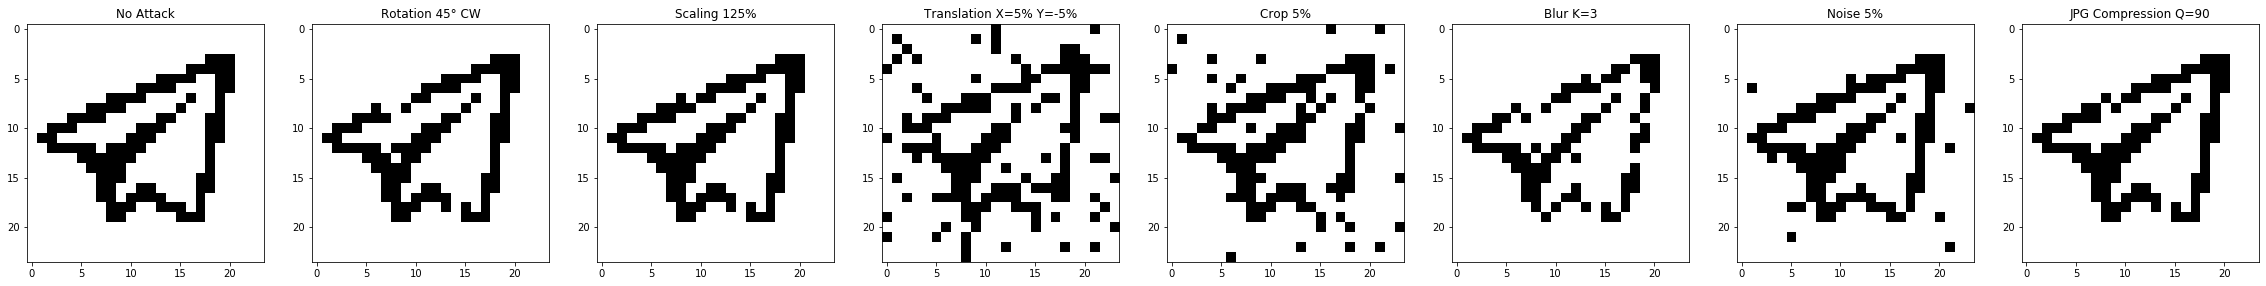

In [32]:
TEST_G_TABLE, TEST_G_LOGO = proceso(TEST_G)

clear_output(wait = True)
print(tabulate(
    np.array(TEST_G_TABLE),
    tablefmt='orgtbl'
))

for imgAndTitle in TEST_G_LOGO:
    (image, title) = imgAndTitle
    imgshow([image], [title], 5)

In [33]:
# Different Max Momen

TEST_P = []
for pp in (32, 48, 54):
    pair = ecute(NNN, 24, pp, 0.5)
    TEST_P.append(pair)
    
clear_output(wait = True)
print(tabulate(
    list(map(lambda s: [s[2], s[3], s[4], s[5], s[1]], TEST_P)),
    headers=['N', 'G', 'P', 'D', 'PSNR'], 
    tablefmt='orgtbl'
))

|   N |   G |   P |   D |    PSNR |
|-----+-----+-----+-----+---------|
| 256 |  24 |  32 | 0.5 | 31.1139 |
| 256 |  24 |  48 | 0.5 | 31.0797 |
| 256 |  24 |  54 | 0.5 | 31.1764 |


| N                      | 256          | 256         | 256         |
| G                      |  24          |  24         |  24         |
| P                      |  32          |  48         |  54         |
| D                      |   0.5        |   0.5       |   0.5       |
| PSNR                   |  31.1139     |  31.0797    |  31.1764    |
| No Attack              |   0          |   0         |   0         |
| Rotation 45° CW        |   0.0104167  |   0.0538194 |   0.0642361 |
| Scaling 125%           |   0.00347222 |   0.0347222 |   0.0399306 |
| Translation X=5% Y=-5% |   0.125      |   0.0555556 |   0.03125   |
| Crop 5%                |   0.0659722  |   0.0208333 |   0.0121528 |
| Blur K=3               |   0.0399306  |   0.0850694 |   0.109375  |
| Noise 5%               |   0.0243056  |   0.0347222 |   0.0190972 |
| JPG Compression Q=90   |   0.00520833 |   0.0329861 |   0.0295139 |


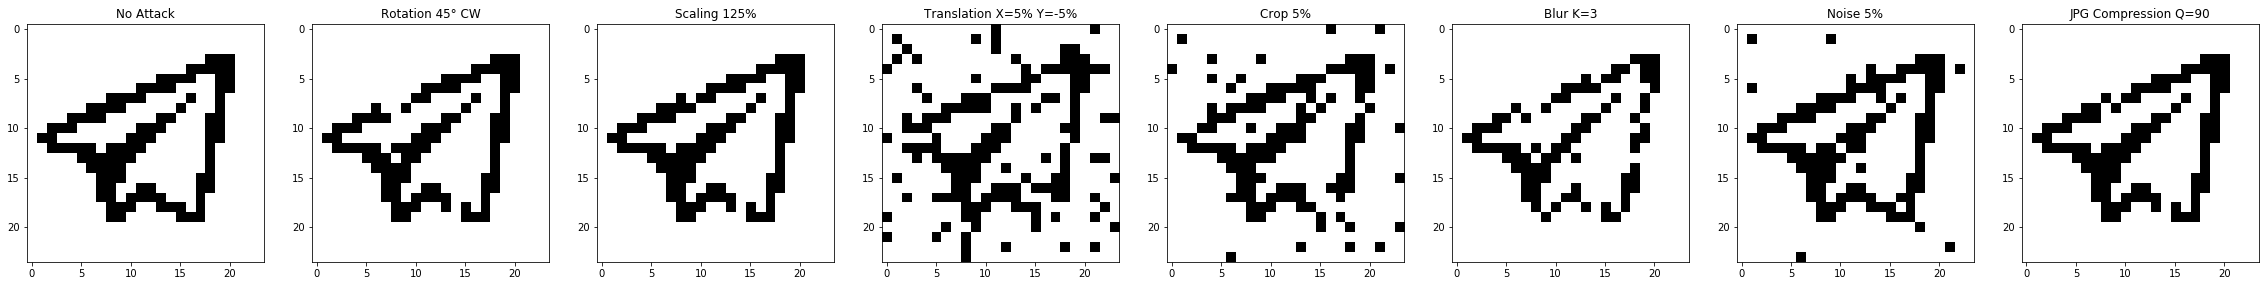

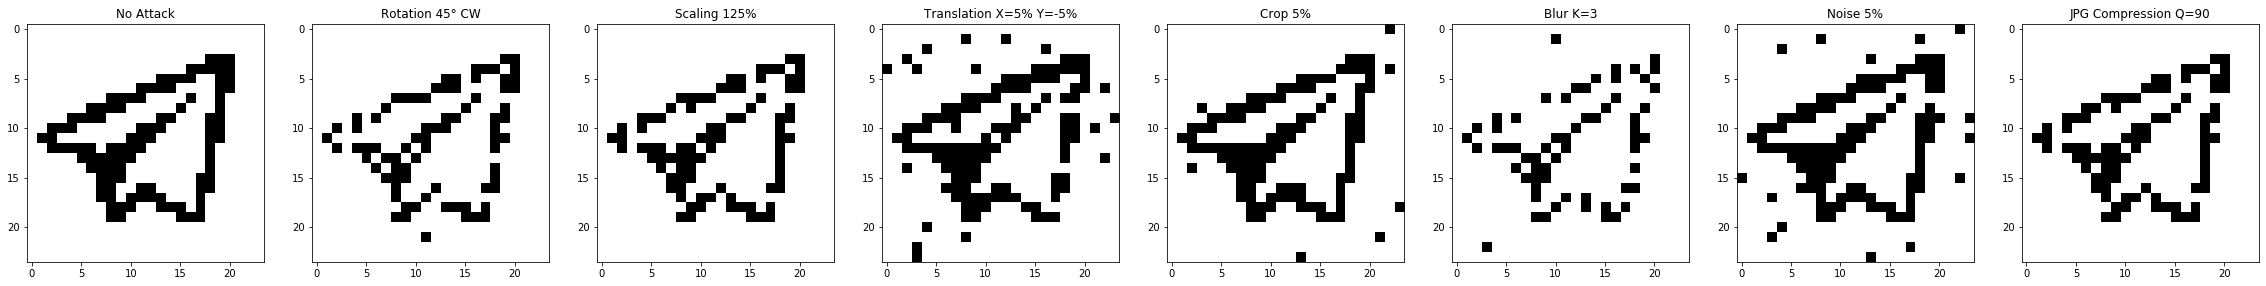

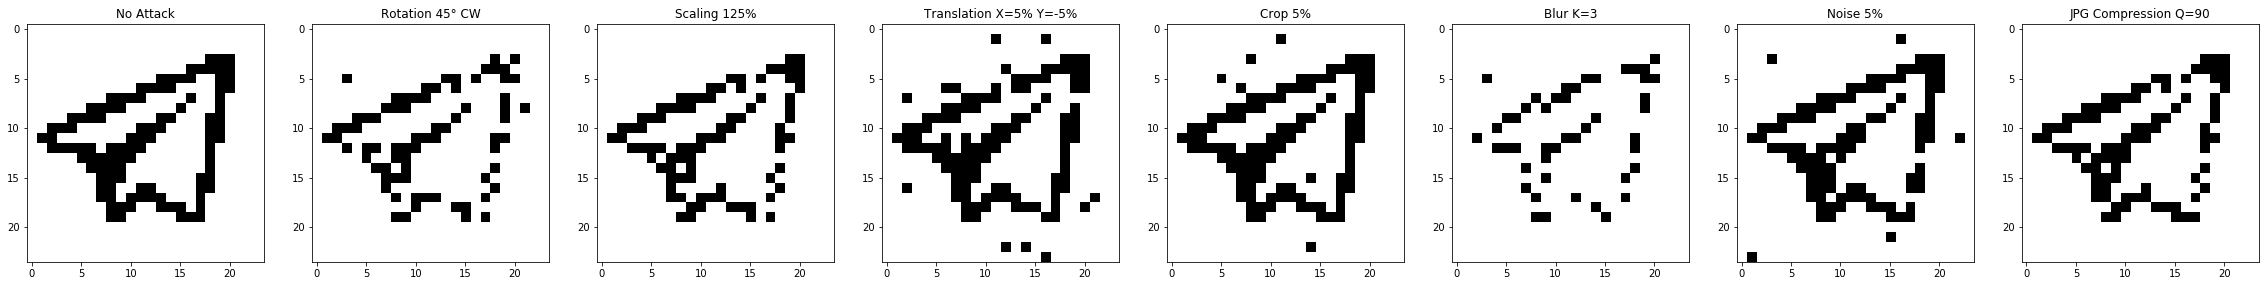

In [34]:
TEST_P_TABLE, TEST_P_LOGO = proceso(TEST_P)

clear_output(wait = True)
print(tabulate(
    np.array(TEST_P_TABLE),
    tablefmt='orgtbl'
))

for imgAndTitle in TEST_P_LOGO:
    (image, title) = imgAndTitle
    imgshow([image], [title], 5)